# Trabalho 1 - Introdução a Teoria da Informação

**Alunos:** Itamar Filho - 20180026510, João Pedro Teixeira - 20180028453, Igor Simões

**Algoritmo Utilizado:** LZW


## Algoritmo base de Encode
Feito com base nas aulas sobre LZW. Versão simples usando as estruturas de dados Dicionário e Tupla padrões do Python.

```py
def encode(original_data: list, original_set: set, verbose: bool = True)->tuple:
        dictionary = {(value,): i for i, value in enumerate(original_set)}
        output = []
        current_arr = (original_data[0],)
        next_idx = len(original_set)

        for num in self.original_data[1:]:
            combined_arr = current_arr + (num,)
            if combined_arr in dictionary:
                current_arr = combined_arr
            else:
                output.append(dictionary[current_arr])
                dictionary[combined_arr] = next_idx
                next_idx += 1
                current_arr = (num,)

        if current_arr:
            output.append(dictionary[current_arr])
            combined_arr = current_arr + (-1,)
            dictionary[combined_arr] = next_idx

        return output, dictionary
```

## Algoritmo base de Decode
Feito com base nas aulas sobre LZW. Versão simples usando as estruturas de dados Dicionário e Tupla padrões do Python.
```py
def decode(encoded_data: list, data_set: set, verbose: bool = True)->list:
        reverse_dictionary = {i: (value,) for i, value in enumerate(sorted(data_set))}
        current_arr = encoded_data[0]
        output = [reverse_dictionary[current_arr]]

        for idx in encoded_data[1:]:
            if idx in reverse_dictionary:
                decoded_arr = reverse_dictionary[idx]
            else:
                decoded_arr = reverse_dictionary[current_arr] + (reverse_dictionary[current_arr][0],)

            output.append(decoded_arr)
            combined_arr = reverse_dictionary[current_arr] + (decoded_arr[0],)
            reverse_dictionary[len(reverse_dictionary)] = combined_arr
            current_arr = idx

        return [item for sublist in output for item in sublist]
```

## Arquivo Corpus16MB.txt

**Formato do arquivo:** Texto

**Tamanho:** 15.6 MB 

### Compressão usando alfabeto adaptável

```py
from compression import LZW

input_file_path = "test/data/corpus16MB.txt"
output_file_path = "test/data/encoded_corpus16MB"

lzw = LZW()
lzw.encode_from_file(input_file_path, verbose=True)
lzw.save_encoded_data(output_file_path)
```

In [27]:
%timeit !python encode_corpus_without_k.py

8.09 s ± 159 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Tamanho do arquivo gerado:** 10.3 MB 

### Descompressão para alfabeto adaptável

```py
from compression import LZW
from compression.helpers import read_data

LZW().decode_from_file("test/data/encoded_corpus16MB.pickle",
                       "test/data/decoded_corpus16MB.txt")
decoded_data, _ = read_data("test/data/decoded_corpus16MB.txt", True)
original_data, _ = read_data("test/data/corpus16MB.txt", True)

print("Verificando se arquivo decodificado é igual ao original: ",
      decoded_data == original_data)

```

In [28]:
%timeit !python decode_corpus_without_k.py

Verificando se arquivo decodificado é igual ao original:  True
Verificando se arquivo decodificado é igual ao original:  True
Verificando se arquivo decodificado é igual ao original:  True
Verificando se arquivo decodificado é igual ao original:  True
Verificando se arquivo decodificado é igual ao original:  True
Verificando se arquivo decodificado é igual ao original:  True
Verificando se arquivo decodificado é igual ao original:  True
Verificando se arquivo decodificado é igual ao original:  True
6.45 s ± 151 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Compressão com dicionário variando por k

```py
from compression import LZW
from compression.helpers import read_data
import os

file = "corpus16MB.txt"
times = []
RC1 = []
RC2 = []

with open(f"test/data/log_{file}.txt", "w") as f:
    f.write(f"dict_k\t\t| Time\t\t| RC1\t\t| RC2\n")

len_original_file = os.path.getsize(f"test/data/{file}")
for dict_k in range(9, 17):
    lzw = LZW(dictionary_k=dict_k)
    output, dictionary, total_time = lzw.encode_from_file(
        f"test/data/{file}", False)

    times.append(total_time)

    lzw.save_encoded_data(f"test/data/varying_k/encoded_{file}")
    del lzw

    LZW().decode_from_file(
        f"test/data/varying_k/encoded_{file}.{dict_k}", f"test/data/varying_k/decoded_{file}_with_k{dict_k}.txt")
    decoded_data, _ = read_data(
        f"test/data/varying_k/decoded_{file}_with_k{dict_k}.txt", False)
    original_data, _ = read_data(f"test/data/{file}", False)

    len_encoded_file = os.path.getsize(
        f"test/data/varying_k/encoded_{file}.{dict_k}")

    RC1.append(len_original_file/len_encoded_file)
    RC2.append(len_original_file/(len(output)*dict_k/8))

    with open(f"test/data/log_{file}.txt", "a") as f:
        f.write(
            f"{dict_k}\t\t| {total_time:.4}\t\t| {RC1[-1]:.4}\t\t| {RC2[-1]:.4}\n")
```

In [29]:
!python encode_corpus_with_k.py

#### Gráficos variando k

In [30]:
# Initialize empty lists for total_time, RC1 and RC2
total_time_list = []
RC1_list = []
RC2_list = []

# Open the file for reading
with open('test/data/log_corpus16MB.txt.txt', 'r') as f:
    # Read each line in the file
    for line in f:
        if "dict_k" in line:
            continue
        # Split the line into separate values using the tab delimiter
        dict_k, total_time, RC1, RC2 = line.strip().split('\t\t| ')
        # Append the values to their respective lists
        total_time_list.append(float(total_time))
        RC1_list.append(float(RC1))
        RC2_list.append(float(RC2))

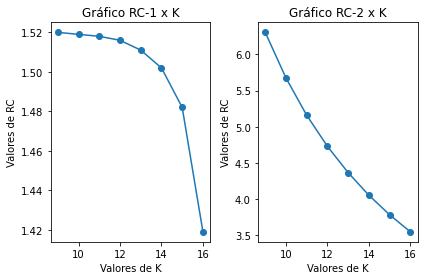

In [31]:
from matplotlib import pyplot as plt

plt.subplot(1, 2, 1)
plt.plot(range(9,17), RC1_list)
plt.scatter(range(9,17), RC1_list)
plt.title('Gráfico RC-1 x K')
plt.xlabel('Valores de K')
plt.ylabel('Valores de RC')
plt.subplot(1, 2, 2)
plt.plot(range(9,17), RC2_list)
plt.scatter(range(9,17), RC2_list)
plt.title('Gráfico RC-2 x K')
plt.xlabel('Valores de K')
plt.ylabel('Valores de RC')
plt.tight_layout()
plt.show()

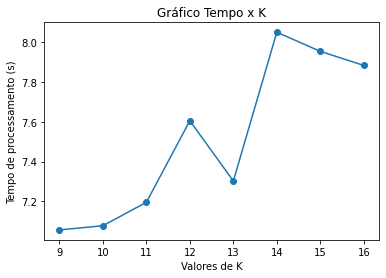

In [32]:
plt.plot(range(9,17), total_time_list)
plt.scatter(range(9,17), total_time_list)
plt.title('Gráfico Tempo x K')
plt.xlabel('Valores de K')
plt.ylabel('Tempo de processamento (s)')
plt.show()

## Arquivo disco.mp4

**Formato do arquivo:** mp4

**Tamanho:** 2.1 MB 

### Compressão usando alfabeto adaptável

```py
from compression import LZW

input_file_path = "test/data/disco.mp4"
output_file_path = "test/data/encoded_disco"

lzw = LZW()
lzw.encode_from_file(input_file_path, verbose=False)
lzw.save_encoded_data(output_file_path)
```

In [33]:
%timeit !python encode_disco_without_k.py

1.33 s ± 32.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Tamanho do arquivo gerado:** 3.8 MB

### Descompressão usando alfabeto adaptável

```py
from compression import LZW
from compression.helpers import read_data

LZW().decode_from_file("test/data/encoded_disco.pickle",
                       "test/data/decoded_disco.mp4")

decoded_data, _ = read_data("test/data/decoded_disco.mp4", False)
original_data, _ = read_data("test/data/disco.mp4", False)

print("Verificando se arquivo decodificado é igual ao original: ",
      decoded_data == original_data)
```

In [34]:
%timeit !python decode_disco_without_k.py

Verificando se arquivo decodificado é igual ao original:  True
Verificando se arquivo decodificado é igual ao original:  True
Verificando se arquivo decodificado é igual ao original:  True
Verificando se arquivo decodificado é igual ao original:  True
Verificando se arquivo decodificado é igual ao original:  True
Verificando se arquivo decodificado é igual ao original:  True
Verificando se arquivo decodificado é igual ao original:  True
Verificando se arquivo decodificado é igual ao original:  True
1.54 s ± 21.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Compressão e Descompressão com dicionário variando por k

```py
from compression import LZW
from compression.helpers import read_data
import os

file = "disco.mp4"
times = []
RC1 = []
RC2 = []

with open(f"test/data/log_{file}.txt", "w") as f:
    f.write(f"dict_k\t\t| Time\t\t| RC1\t\t| RC2\n")

len_original_file = os.path.getsize(f"test/data/{file}")
for dict_k in range(9, 17):
    lzw = LZW(dictionary_k=dict_k)
    output, dictionary, total_time = lzw.encode_from_file(
        f"test/data/{file}", False)

    times.append(total_time)

    lzw.save_encoded_data(f"test/data/varying_k/encoded_{file}")
    del lzw

    LZW().decode_from_file(
        f"test/data/varying_k/encoded_{file}.{dict_k}", f"test/data/varying_k/decoded_{file}_with_k{dict_k}.txt")
    decoded_data, _ = read_data(
        f"test/data/varying_k/decoded_{file}_with_k{dict_k}.txt", False)
    original_data, _ = read_data(f"test/data/{file}", False)

    len_encoded_file = os.path.getsize(
        f"test/data/varying_k/encoded_{file}.{dict_k}")

    RC1.append(len_original_file/len_encoded_file)
    RC2.append(len_original_file/(len(output)*dict_k/8))

    with open(f"test/data/log_{file}.txt", "a") as f:
        f.write(
            f"{dict_k}\t\t| {total_time:.4}\t\t| {RC1[-1]:.4}\t\t| {RC2[-1]:.4}\n")

```

In [35]:
!python encode_disco_with_k.py

#### Gráficos variando k

In [36]:
# Initialize empty lists for total_time, RC1 and RC2
total_time_list = []
RC1_list = []
RC2_list = []

# Open the file for reading
with open('test/data/log_disco.mp4.txt', 'r') as f:
    # Read each line in the file
    for line in f:
        if "dict_k" in line:
            continue
        # Split the line into separate values using the tab delimiter
        dict_k, total_time, RC1, RC2 = line.strip().split('\t\t| ')
        # Append the values to their respective lists
        total_time_list.append(float(total_time))
        RC1_list.append(float(RC1))
        RC2_list.append(float(RC2))

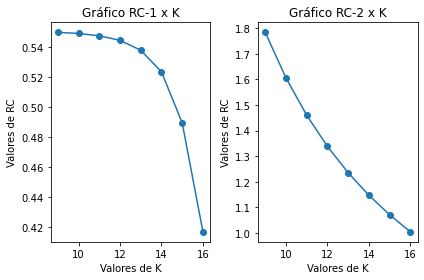

In [37]:
from matplotlib import pyplot as plt

plt.subplot(1, 2, 1)
plt.plot(range(9,17), RC1_list)
plt.scatter(range(9,17), RC1_list)
plt.title('Gráfico RC-1 x K')
plt.xlabel('Valores de K')
plt.ylabel('Valores de RC')
plt.subplot(1, 2, 2)
plt.plot(range(9,17), RC2_list)
plt.scatter(range(9,17), RC2_list)
plt.title('Gráfico RC-2 x K')
plt.xlabel('Valores de K')
plt.ylabel('Valores de RC')
plt.tight_layout()
plt.show()

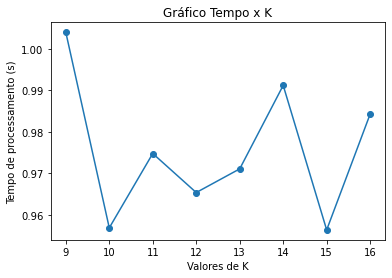

In [38]:
plt.plot(range(9,17), total_time_list)
plt.scatter(range(9,17), total_time_list)
plt.title('Gráfico Tempo x K')
plt.xlabel('Valores de K')
plt.ylabel('Tempo de processamento (s)')
plt.show()